In [86]:
#!pip install pykml
#!pip install pyshp

In [87]:
import pandas as pd
from pykml.factory import KML_ElementMaker as KML
from lxml import etree
import shapefile as shp
import matplotlib.pyplot as plt
import numpy as np

In [88]:
file_name = 'relatorios/relatorio_396.csv'

In [89]:
df = pd.read_csv(filepath_or_buffer=file_name, sep=';', encoding= 'unicode_escape')

In [90]:
filtro_intervencao = df['Tipo de Intervenção'] == 'Cadastro apenas da barragem'
filtro_status1 = df['Status'] != 'Concluído'
filtro_status2 = df['Status'] != 'Desativado'
filtro_status3 = df['Status'] != 'Em andamento'

In [91]:
df_filtrado = df[filtro_status1 & filtro_status2 & filtro_status3 & filtro_intervencao]

In [92]:
df_filtrado.shape

(89, 25)

In [93]:
df_filtrado.head()

,Número do cadastro,Número da portaria,Nome do usuário de água,Natureza da intervenção,Tipo da Fonte de Captação,Tipo de Intervenção,Classificação,Status,Observação,Data de início do cadastro,...,Finalidades de Uso,Bacia Hidrográfica,Corpo Hídrico,Sistema Aquífero,Município,Nome da Geometria,Latitude,Longitude,Latitude (ponto final),Longitude (ponto final)
1,2020/005.099,-,BT GERADORA DE ENERGIA ELETRICA S.A.,Água Superficial,Barragem de nível,Cadastro apenas da barragem,Cadastro,Aguardando alterações de dados inconsistentes,-,27/03/2020,...,Aproveitamento hidrelétrico,Bacia Hidrográfica do Rio da Várzea,Rio Guarita,-,Erval Seco,Ponto 1,"-53,5789","-27,5612",-,-
7,2020/002.866,-,LINHA ONZE OESTE ENERGIA LTDA,Água Superficial,Barragem de nível,Cadastro apenas da barragem,Cadastro,Aguardando formalização de documentos,-,19/02/2020,...,Aproveitamento hidrelétrico,Bacia Hidrográfica do Rio Ijuí,Rio Ijuí,-,Coronel Barros,Ponto 1,"-54,0045500199785","-28,3511124417778",-,-
8,2020/002.683,-,Cooperativa de Geração de Energia e Desenvolvi...,Água Superficial,Barragem de nível,Cadastro apenas da barragem,Cadastro,Aguardando formalização de documentos,-,17/02/2020,...,Aproveitamento hidrelétrico,Bacia Hidrográfica dos Rios Turvo - Santa Rosa...,Rio Buricá,-,Chiapetta,Ponto 1,"-53,9701307613505","-27,9612491935233",-,-
12,2020/001.754,-,BORTOLON AGROCOMERCIAL EIRELI,Água Superficial,Barragem de acumulação,Cadastro apenas da barragem,Cadastro,Em análise,-,31/01/2020,...,Aproveitamento hidrelétrico,Bacia Hidrográfica dos Rios Apuaê - Inhandava,Rio Socorro,-,Vacaria,Ponto 1,"-50,8559701377817","-28,2990821433521",-,-
13,2020/001.523,-,ENERBIO SERVICOS DE ENGENHARIA LTDA,Água Superficial,Barragem de nível,Cadastro apenas da barragem,Cadastro,Em análise,-,28/01/2020,...,Aproveitamento hidrelétrico,Bacia Hidrográfica do Rio da Várzea,Rio Fortaleza,-,Erval Seco,Ponto 1,"-53,5472","-27,4186",-,-


In [94]:
df_filtrado['Status'].unique()

array(['Aguardando alterações de dados inconsistentes',
       'Aguardando formalização de documentos', 'Em análise', 'Concedida',
       'Indeferida'], dtype=object)

In [95]:
aguardando = df_filtrado[df_filtrado['Status'] == 'Aguardando análise'][['Número do cadastro', 'Nome do usuário de água', 'Data de início do cadastro', 'Data de saída do processo']]
aguardando['Data de saída do processo'] = pd.to_datetime(aguardando['Data de saída do processo'], dayfirst=True)
aguardando['Data de início do cadastro'] = pd.to_datetime(aguardando['Data de início do cadastro'], dayfirst=True)
aguardando.sort_values('Data de saída do processo')
aguardando.to_csv('aguardando_analise.csv', index=False)
aguardando

,Número do cadastro,Nome do usuário de água,Data de início do cadastro,Data de saída do processo


In [96]:
aguardando = df_filtrado[df_filtrado['Status'] == 'Em análise'][['Número do cadastro', 'Nome do usuário de água', 'Data de início do cadastro', 'Data de saída do processo']]
aguardando['Data de saída do processo'] = pd.to_datetime(aguardando['Data de saída do processo'], dayfirst=True)
aguardando['Data de início do cadastro'] = pd.to_datetime(aguardando['Data de início do cadastro'], dayfirst=True)
aguardando.sort_values('Data de saída do processo')
aguardando.to_csv('em_analise.csv', index=False)
aguardando

,Número do cadastro,Nome do usuário de água,Data de início do cadastro,Data de saída do processo
12,2020/001.754,BORTOLON AGROCOMERCIAL EIRELI,2020-01-31,2020-04-06
13,2020/001.523,ENERBIO SERVICOS DE ENGENHARIA LTDA,2020-01-28,2020-04-09
27,2019/025.605,CONSTRUNÍVEL ENERGIAS RENOVÁVEIS LTDA,2019-12-17,2020-04-08
36,2019/023.469,ENERBIO SERVICOS DE ENGENHARIA LTDA,2019-11-25,2020-04-15
45,2019/020.046,Vertente Engenharia Ltda,2019-10-15,2020-04-14
75,2019/009.268,RIO DO FRADE GERAÇÃO DE ENERGIA LTDA,2019-05-27,2019-08-02
94,2019/005.142,TOUROS IV ENERGÉTICA S.A.,2019-04-01,2020-02-14
143,2018/033.655,Pablo Rodrigo Ferreira Romeiro,2018-12-03,2020-04-14
144,2018/033.376,Agropecuaria Fockink Ltda,2018-11-29,2020-01-07
270,2017/030.507,Aecogeo Soluções Ambientais Ltda,2017-09-28,2020-04-15


In [97]:
shp_path = "estados_2010.shp"
sf = shp.Reader(shp_path)

In [98]:
sf.records()[22]

Record #22: [23, 'Rio Grande do Sul', 'RS', '1', '43']

In [99]:
def plot_shape(idt, ax, sf):
    shape_ex = sf.shape(idt)
    x_lon = np.zeros((len(shape_ex.points),1))
    y_lat = np.zeros((len(shape_ex.points),1))
    for ip in range(len(shape_ex.points)):
        x_lon[ip] = shape_ex.points[ip][0]
        y_lat[ip] = shape_ex.points[ip][1]
    ax.plot(x_lon,y_lat,c='gray') 
    x0 = np.mean(x_lon)
    y0 = np.mean(y_lat)

In [100]:
pie_dict = {}
for s in df_filtrado['Status'].unique():
    ns = sum(df_filtrado['Status'] == s)
    pie_dict[s] = ns

In [101]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

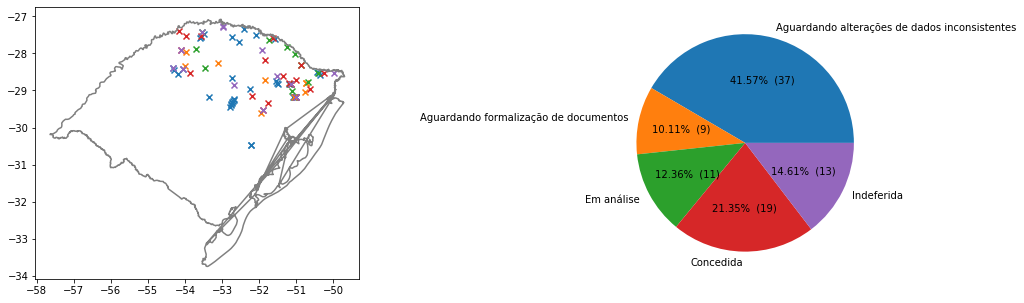

In [102]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))
ax2.pie(pie_dict.values(), autopct=make_autopct(pie_dict.values()), labels=pie_dict.keys())
plot_shape(22, ax1, sf)
for s in df_filtrado['Status'].unique():
    f = df_filtrado['Status'] == s
    x, y = df_filtrado[f]['Latitude'].values, df_filtrado[f]['Longitude'].values
    x, y = [float(i.replace(',','.')) for i in x], [float(i.replace(',','.')) for i in y]
    ax1.scatter(x, y, label = s, marker='x')
ax1.axis('scaled')
#fig.suptitle('Status dos processos de hidrelétricas do SIOUT')
#ax2.legend(loc='upper right')
plt.savefig('Status', bbox_inches='tight')

In [103]:
doc = KML.Document()

In [104]:
icons = {
    'verde':'http://maps.google.com/mapfiles/kml/pushpin/grn-pushpin.png',
    'amarelo':'http://maps.google.com/mapfiles/kml/pushpin/ylw-pushpin.png',
    'vermelho':'http://maps.google.com/mapfiles/kml/pushpin/red-pushpin.png'
}

In [105]:
for color in icons:
    
    s = KML.Style(
            KML.IconStyle(
                KML.scale(1.2),
                KML.Icon(
                    KML.href(icons[color])
                ),
            ),
            id=color,
        )
    
    doc.append(s)

In [106]:
fld_ag_doc = KML.Folder(KML.name('Aguardando formalização de documentos'))
fld_ag_an = KML.Folder(KML.name('Aguardando análise'))
fld_ag_alt = KML.Folder(KML.name('Aguardando alterações de dados inconsistentes'))
fld_an = KML.Folder(KML.name('Em análise'))
fld_conc = KML.Folder(KML.name('Concedida'))
fld_ind = KML.Folder(KML.name('Indeferida'))

In [107]:
for index, row in df_filtrado.iterrows():
    name = row['Número do cadastro']
    usuario = row['Nome do usuário de água']
    status = row['Status']
    corpo_hidrico = row['Corpo Hídrico']
    municipio = row['Município']
    description = '''
Usuario: {}
Status: {}
Municipio: {}
Corpo Hidrico: {}
    '''.format(usuario, status, municipio, corpo_hidrico)
    lat = row['Latitude'].replace(',','.')
    long = row['Longitude'].replace(',','.')
    coordinates = lat+','+long
    
    if status == 'Concedida':
        style = '#verde'
    elif status == 'Indeferida':
        style = '#vermelho'
    else:
        style = '#amarelo'
    
    p = KML.Placemark(
        KML.name(name),
        KML.Point(KML.coordinates(coordinates)),
        KML.description(description),
        KML.styleUrl(style))
    
    if status == 'Aguardando formalização de documentos':
        fld_ag_doc.append(p)
    elif status == 'Aguardando análise':
        fld_ag_an.append(p)
    elif status == 'Aguardando alterações de dados inconsistentes':
        fld_ag_alt.append(p)
    elif status == 'Em análise':
        fld_an.append(p)
    elif status == 'Concedida':
        fld_conc.append(p)
    elif status == 'Indeferida':
        fld_ind.append(p)

In [108]:
doc.append(fld_ag_doc)
doc.append(fld_ag_an)
doc.append(fld_ag_alt)
doc.append(fld_an)
doc.append(fld_conc)
doc.append(fld_ind)

In [109]:
kml_file_path = 'hidreletricas_SIOUT.kml'

In [110]:
kml_str = etree.tostring(doc, pretty_print=True).decode('utf-8')

In [111]:
f = open(kml_file_path, "w")
f.write(kml_str)
f.close()